## Методы обработки естественных языков

### Практическая работа 3

In [1]:
import os
import nltk
import spacy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment import SentimentIntensityAnalyzer

from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [2]:
CHAPTERS_NUM = 16  # количество глав, которые будут использоваться в анализе
TOPICS_NUM   = 4   # количество тем

In [3]:
!spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.5 MB/s  0:00:02 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
def read_chapters(chapter_num):
    chapters = []
    for i in range(chapter_num):
        filename = os.path.join("data", f"book_chapter_{i+1}.txt")
        with open(filename, "r", encoding="utf-8") as f:
            chapter_content = f.read()
            chapters.append(chapter_content)
    return chapters

chapters = read_chapters(CHAPTERS_NUM)

### Нормализация

In [5]:
nlp = spacy.load("en_core_web_sm")

def normalize_text(text):
    doc    = nlp(text)
    lemmas = [
        token.lemma_.lower()
        for token in doc if token.is_alpha and not token.is_stop
    ]
    return " ".join(lemmas)

normalized_chapters = []
for i in range(CHAPTERS_NUM):
    normalized_chapters.append(normalize_text(chapters[i]))

print("Главы книги после нормализации")
for i in range(CHAPTERS_NUM):
    print(f"    Глава {i+1}: {normalized_chapters[i][:20]}...")

Главы книги после нормализации
    Глава 1: obstinate north wind...
    Глава 2: observer close hand ...
    Глава 3: child remain motionl...
    Глава 4: kind band leave chil...
    Глава 5: seven evening wind d...
    Глава 6: child thing dumb won...
    Глава 7: run breathless rando...
    Глава 8: snowstorm mystery oc...
    Глава 9: hooker gulf portland...
    Глава 10: man board craft abso...
    Глава 11: old man chief band n...
    Глава 12: mist deform sort ine...
    Глава 13: grow preoccupation d...
    Глава 14: wild jubilee delight...
    Глава 15: characteristic snows...
    Глава 16: skipper helm burst b...


### Анализатор тональности

In [6]:
nltk.download("vader_lexicon", quiet=True)

def get_text_sentiment(text):
    sia    = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    return max(scores, key=scores.get)

labels_dict = {
    "neu":      "нейтральную",
    "pos":      "положительную",
    "neg":      "отрицательную",
    "compound": "сложную",
}

for i in range(CHAPTERS_NUM):
    print(f"Глава {i+1} имеет {labels_dict[get_text_sentiment(normalized_chapters[i])]} тональность")

Глава 1 имеет сложную тональность
Глава 2 имеет сложную тональность
Глава 3 имеет нейтральную тональность
Глава 4 имеет нейтральную тональность
Глава 5 имеет нейтральную тональность
Глава 6 имеет нейтральную тональность
Глава 7 имеет нейтральную тональность
Глава 8 имеет нейтральную тональность
Глава 9 имеет нейтральную тональность
Глава 10 имеет нейтральную тональность
Глава 11 имеет сложную тональность
Глава 12 имеет нейтральную тональность
Глава 13 имеет нейтральную тональность
Глава 14 имеет нейтральную тональность
Глава 15 имеет нейтральную тональность
Глава 16 имеет нейтральную тональность


### Векторизация

In [7]:
vectorizer  = TfidfVectorizer(
    max_df=0.8,
    min_df=2,
    max_features=1000,
    stop_words="english",
)
tfidf_model   = vectorizer.fit_transform(normalized_chapters)
feature_names = vectorizer.get_feature_names_out()
print(f"10 признаков из матрицы TF-IDF: {', '.join(feature_names[:10])}")

10 признаков из матрицы TF-IDF: aback, abaft, abandon, abrupt, absolutely, absorb, abyss, accept, acceptance, accomplice


### LSA

In [8]:
def print_heatmap(matrix):
    labels = [f"Глава {i+1}" for i in range(CHAPTERS_NUM)]
    plt.figure(figsize=(16, 8))
    sns.heatmap(
        matrix,
        xticklabels=labels,
        yticklabels=labels,
        cmap="Greys",
        annot=True,
        fmt=".2f",
        square=True,
    )
    plt.title("Тепловая карта семантической близости глав")
    plt.xticks(rotation=45)
    plt.show()

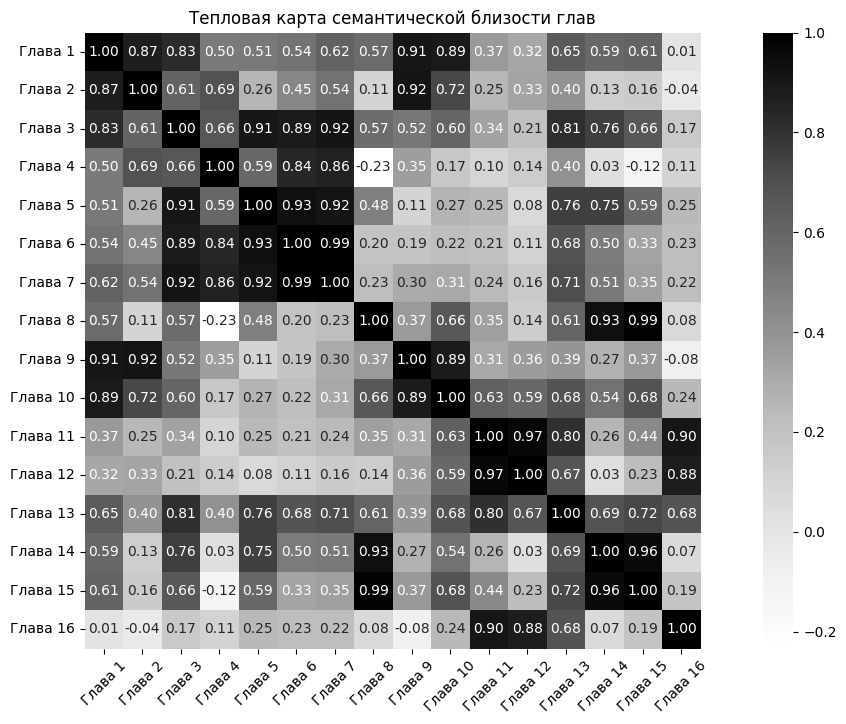

In [9]:
lsa       = TruncatedSVD(n_components=TOPICS_NUM, random_state=0)
lsa_model = lsa.fit_transform(tfidf_model)

similarity_matrix = cosine_similarity(lsa_model)
print_heatmap(similarity_matrix)

Можно заметить, что первые 7 глав имеют высокую семантическую близость друг с другом.\
Также глава под номером 13 является наиболее схожей с остальными главами, чем другие.

In [10]:
n_words = 5
print(f"Список из {n_words} самых значимых слов в теме")
for i, topic in enumerate(lsa.components_):
    idxs = topic.argsort()[-n_words:][::-1]
    print(f"    Тема {i+1}: {', '.join([feature_names[idx] for idx in idxs])}")

Список из 5 самых значимых слов в теме
    Тема 1: child, hooker, wave, doctor, time
    Тема 2: child, gibbet, corpse, plain, chain
    Тема 3: child, basque, doctor, skipper, time
    Тема 4: bell, doctor, child, skipper, chain


### Doc2Vec

In [11]:
tagged_data = [
    TaggedDocument(words=doc.split(" "), tags=[f"DOC_{i}"])
    for i, doc in enumerate(normalized_chapters)
]

In [12]:
doc2vec_model = Doc2Vec(min_count=2, epochs=32, dm=0, workers=4, seed=0)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(
    tagged_data,
    total_examples=doc2vec_model.corpus_count,
    epochs=doc2vec_model.epochs,
)
doc2vec_vectors = np.array([
    doc2vec_model.dv[f"DOC_{i}"] for i in range(len(normalized_chapters))
])

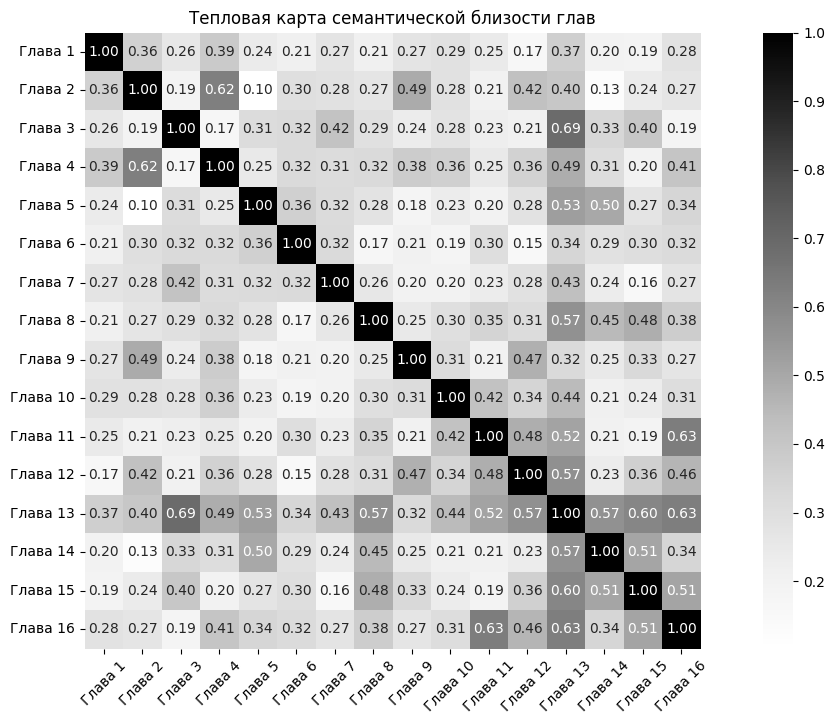

In [13]:
doc2vec_similarity = cosine_similarity(doc2vec_vectors)
print_heatmap(doc2vec_similarity)

Можно заметить, что главы (2 и 4), (3 и 13), (11 и 16) имеют друг с другом высокую семантическую близость.\
Также глава под номером 13 является наиболее схожей с остальными главами, чем другие (как и в *LSA*)

### Word2Vec

In [14]:
sentences = [doc.split(" ") for doc in normalized_chapters]
word2vec_model = Word2Vec(
    sentences=sentences,
    min_count=2,
    seed=0,
    sg=1,
)

In [15]:
user_input = input(
    "Введите слова, схожесть которых " \
    "Вы хотите увидеть (слова должны быть на английском языке)"
).split(',')
if user_input == [""]:
    user_input = [w for w in word2vec_model.wv.key_to_index if len(w) > 3][:5]

In [16]:
print("Семантически похожие слова:")
for word in user_input:
    try:
        similar_words = word2vec_model.wv.most_similar(word, topn=3)
        print(f"    {word}: {', '.join([s[0] for s in similar_words])}")
    except KeyError:
        print(f"    {word}: нет похожих слов:(")

Семантически похожие слова:
    child: night, wind, away
    wind: hear, mouth, take
    like: storm, wind, dead
    hooker: wind, take, sea
    time: appear, corpse, yes
